In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
# import gradient 
import torch

from nb_functions import nearest_neighbors_with_occlusion_kdtree_smart, distance_cutoff, cutoff_and_knn, knn



In [32]:
class Simulation:
    def __init__(self, n_cells, start_positions=None):

        if start_positions is not None:
            sp = torch.tensor(start_positions, requires_grad=True)
            self.cell_rs = sp
            self.n_cells = int(np.sqrt(len(start_positions)))

            self.cell_qs = np.array([[0.0,1.0] for _ in range(n_cells**2)])
            self.cell_qs = torch.tensor(self.cell_qs, requires_grad=True)

        else:
            self.n_cells = n_cells
            self.cell_qs = np.array([[0.0,1.0] for _ in range(n_cells**2)])
            self.cell_rs = np.random.rand(n_cells**2, 2)*10 - 5

            self.cell_rs = torch.tensor(self.cell_rs, requires_grad=True)
            self.cell_qs = torch.tensor(self.cell_qs, requires_grad=True)

        self.dt = 0.03
        
        self.nbs = self.voronoi_neighbors(self.cell_rs.detach().numpy())

        self.elongated_cells = torch.tensor([False for _ in range(n_cells**2)])

        self.time : float = 0.0

        # self.nb_function = lambda points: distance_cutoff(points, 5)
        self.nb_function = lambda points: cutoff_and_knn(points, cutoff = 10, k = 6)


        self.elongated_cells[30] = True
        self.elongated_cells[45] = True
        self.elongated_cells[65] = True

    def S(self, ri, rj):
        return 1

    def V(self, ri, rj, qi, qj, elongated=False):
        dij = rj - ri
        
        # rij = np.linalg.norm(dij)
        # torch len
        rij = torch.norm(dij) + 1e-6

        if elongated:
            rij_t = rij - (torch.abs(torch.dot(dij/rij, qi))-0.5)*0.0
        else:

            rij_t = rij

        return torch.exp(-rij_t) - self.S(ri, rj)*torch.exp(-rij_t/5)


    def voronoi_neighbors(self, points):
        vor = Voronoi(points) 
        neighbors = {i: set() for i in range(len(points))}
        for i, j in vor.ridge_points:
            if i == -1 or j == -1:
                continue
            if i == j:
                continue
            neighbors[i].add(j)
            neighbors[j].add(i)
        return neighbors


    def step(self, should_get_new_nbs):
        if should_get_new_nbs:
            self.nbs = list(self.nb_function(self.cell_rs.detach().numpy()))


        for i in range(self.n_cells**2):
            nb = torch.tensor(list(self.nbs[i]), dtype=torch.int32)


            # get V for all neighbors
            V = torch.tensor(0.0)
            for j in nb:
                V += self.V(self.cell_rs[i], self.cell_rs[j], self.cell_qs[i], self.cell_qs[j], self.elongated_cells[j])

            # get gradient of V
            V.backward()

            # update r
            with torch.no_grad():
                self.cell_rs -= self.cell_rs.grad*self.dt
                # add gaussian noise
                self.cell_rs += 0.001*torch.randn_like(self.cell_rs)

            # zero grad
            self.cell_rs.grad.zero_()


    def show(self):
        plt.scatter(self.cell_rs.detach().numpy()[:,0], self.cell_rs.detach().numpy()[:,1], c = self.elongated_cells.numpy())
        plt.title(f"Time: {self.time:.3} | Step: {int(self.time/self.dt)}")
        plt.show()

    def run(self):
        self.show()
        for i in range(800):
            newnbs = i%50 == 0

            self.step(should_get_new_nbs = newnbs)

            self.time += self.dt

            if i % 200 == 0:
                self.show()




C:\Users\jakob\AppData\Local\Temp\ipykernel_25168\1772021927.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sp = torch.tensor(start_positions, requires_grad=True)


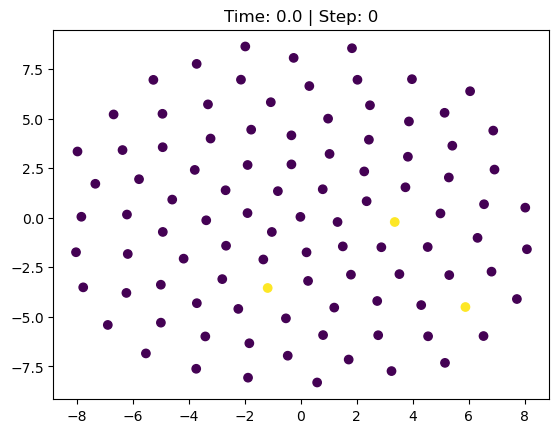

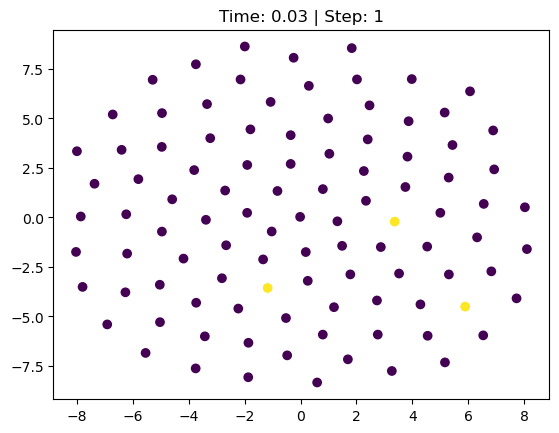

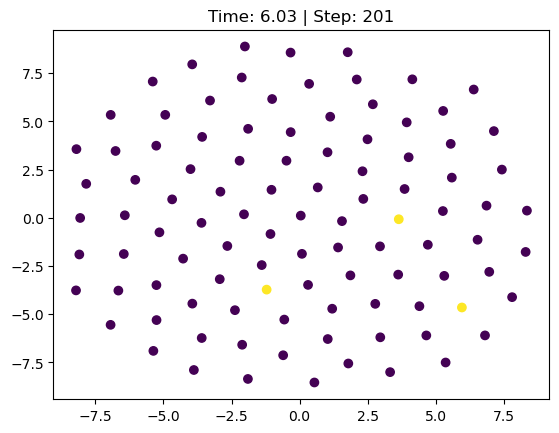

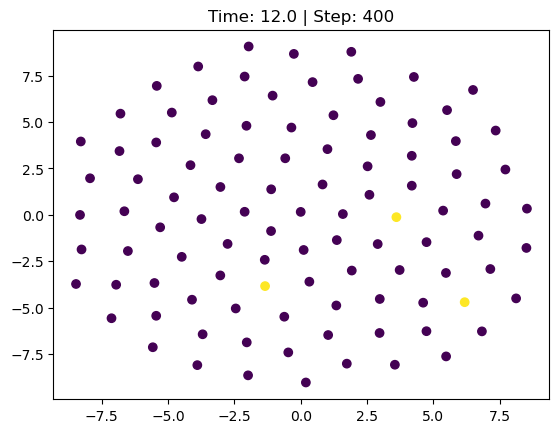

In [ ]:
sim = Simulation(10, eq_poss)
sim.run()

In [16]:
eq_poss = sim.cell_rs

In [17]:
np.save("eq_poss.npy", eq_poss.detach().numpy())